In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

dir = 'final/'
results_fps = [f for f in listdir(dir) if isfile(join(dir, f))]
print(len(results_fps))
results_fps

30


['Burger_etal_aucbandit_BiRRT.csv',
 'Burger_etal_aucbandit_RRTConnect.csv',
 'Burger_etal_default.csv',
 'Burger_etal_gp_RRTConnect.csv',
 'Burger_etal_ompl.csv',
 'Burger_etal_rand_BiRRT.csv',
 'Burger_etal_rand_BKPIECE.csv',
 'Burger_etal_rand_RRTConnect.csv',
 'Burger_etal_rf_BiTRRT.csv',
 'Burger_etal_rf_BKPIECE.csv',
 'Burger_etal_smac_BiTRRT.csv',
 'Burger_etal_smac_BKPIECE.csv',
 'Burger_etal_smac_RRTConnect.csv',
 'Burger_etal_tpe_BiRRT.csv',
 'Burger_etal_tpe_BKPIECE.csv',
 'Burger_etal_tpe_RRTConnect.csv',
 'Cano_etal_aucbandit_BKPIECE.csv',
 'Cano_etal_aucbandit_RRTConnect.csv',
 'Cano_etal_default.csv',
 'Cano_etal_gp_BKPIECE.csv',
 'Cano_etal_gp_RRTConnect.csv',
 'Cano_etal_ompl.csv',
 'Cano_etal_rand_BKPIECE.csv',
 'Cano_etal_rand_RRTConnect.csv',
 'Cano_etal_rf_BKPIECE.csv',
 'Cano_etal_rf_RRTConnect.csv',
 'Cano_etal_smac_BKPIECE.csv',
 'Cano_etal_smac_RRTConnect.csv',
 'Cano_etal_tpe_BKPIECE.csv',
 'Cano_etal_tpe_RRTConnect.csv']

In [ ]:
planner_select = 'Burger_etal'

def comparison_plot(planner_select, planner):
    pass

for ps in ['Cano_etal', 'Burger_etal']:
    default_fn = planner_select+'_default.csv'
    default_df = pd.read_csv(join(dir, default_fn))
    planners = list(default_df['planner'])
    for p in planners:
        plot = comparison_plot(planner_select, p)

#     return plot


Cano_etal
BKPIECEkConfigDefault
Cano_etal_aucbandit_BKPIECE.csv
Cano_etal_gp_BKPIECE.csv
Cano_etal_rand_BKPIECE.csv
Cano_etal_rf_BKPIECE.csv
Cano_etal_smac_BKPIECE.csv
Cano_etal_tpe_BKPIECE.csv


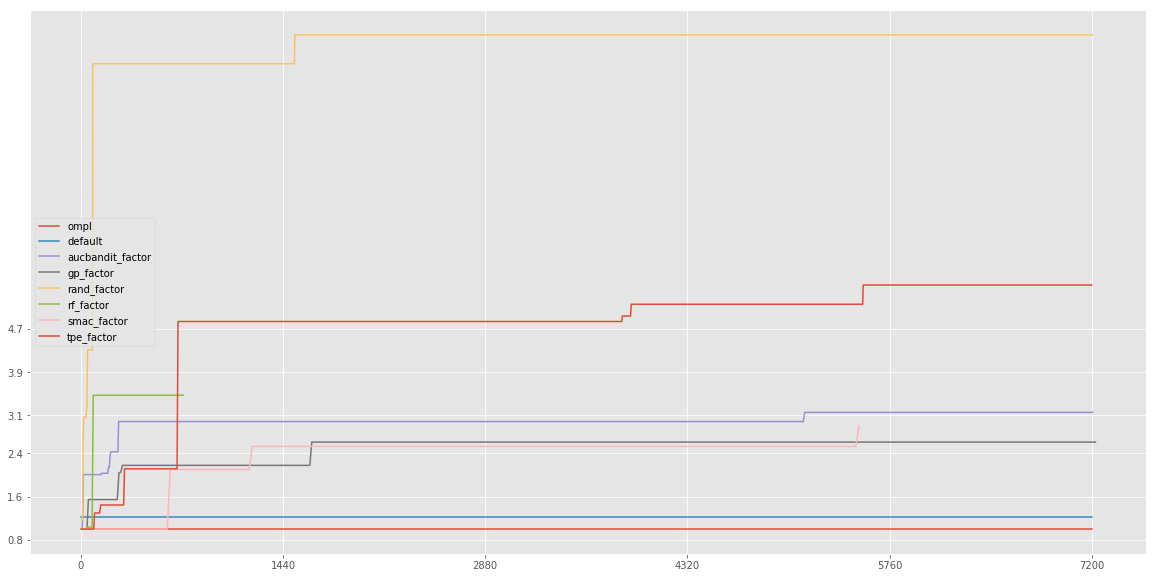

In [22]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

# for f in results_fps:
#     if any(x in f for x in ["default", "ompl"]):
#         print(f)
# Read default df
planner_select = 'Cano_etal'
print(planner_select)

ompl_fn = planner_select+'_ompl.csv'
ompl_df = pd.read_csv(join(dir, ompl_fn))
planners = list(ompl_df['planner'])
# for p in planners:
#

# def comparison_plot(planner_select, planner):
planner = planners[0]
print(planner)
elapsed_time = np.linspace(0, 7200, 500)

ompl = float(ompl_df[(ompl_df['planner'] == planner)]['t_avg_plan_time'])
ompl_df = pd.DataFrame({'elapsed_time': elapsed_time, 'ompl': ompl})
ompl_df['ompl'] = ompl/ompl_df['ompl']
plt.plot('elapsed_time', 'ompl', data=ompl_df)
# sns.regplot(x='elapsed_time', y='ompl', data=ompl_df, fit_reg=True, label='ompl',
#             scatter=False)


default_fn = planner_select+'_default.csv'
default_df = pd.read_csv(join(dir, default_fn))
default = float(
    default_df[(default_df['planner'] == planner)]['t_avg_plan_time'])
default_df = pd.DataFrame({'elapsed_time': elapsed_time, 'default': default})
default_df['default'] = ompl/default_df['default']
plt.plot('elapsed_time', 'default', data=default_df)
# sns.regplot(x='elapsed_time', y='default', data=default_df, fit_reg=True, label='default',
#             scatter=False)


# Planner select filepaths
ps_fps = []
modes = []
speed_up_df = []

for f in results_fps:
    if planner_select in f:
        if not any(x in f for x in ['default', 'ompl']):
            ps_fps.append(f)
            # f = 'Cano_etal_rand_BKPIECE.csv'
            # f = <planner_select>_<mode>_<planner>.csv
            fn = f.split('_')
            planner_fn = fn[-1].split('.')[-2]
            mode = fn[2]
            # Filtering fns for selected planner
            if re.search(planner_fn, planner, re.IGNORECASE):
                print(f)
                mode_df = pd.read_csv(join(dir, f), index_col=False)
                # Remove everything slower than ompl baseline
                # mode_df.drop(mode_df[mode_df.loss >= ompl].index, inplace=True)
                max_speed_up = ompl
                speed_up = list(mode_df['loss'])
                for idx, loss in enumerate(speed_up):
                    if loss < max_speed_up:
                        max_speed_up = loss
                    else:
                        speed_up[idx] = max_speed_up

                mode_df = pd.DataFrame(
                    {'elapsed_time': mode_df['elapsed_time'], mode: speed_up})
                mode_df[mode+'_factor'] = ompl/mode_df[mode]
                plt.plot('elapsed_time', mode+'_factor', data=mode_df)
                # sns.regplot(x='elapsed_time', y=mode+'_factor', data=mode_df, fit_reg=True, label=mode,
                # scatter=False, robust=True, ci=None)
                # sns.lmplot(x='elapsed_time',y=mode+'_factor',data=mode_df, order=5, scatter=True)

plt.xticks([0, 1440, 2880, 4320, 5760, 7200])
plt.yticks([0.8, 1.6, 2.4, 3.1, 3.9, 4.7])
plt.legend()

In [12]:
df = pd.read_csv(join(dir,'Burger_etal_rf_BKPIECE.csv'))
df.head()

,n_trial,elapsed_time,loss,planner,avg_runs,t_avg_run_time,t_avg_plan_time,t_avg_dist,t_avg_path_length,t_avg_success,params
1,4.110242,0.547041,BKPIECEkConfigDefault,1,1.798658,0.547041,1.702806,7.274183,1.0,"{'longest_valid_segment_fraction': 0.005, 'bor...",NaN
2,11.938826,3.000000,BKPIECEkConfigDefault,1,0.000000,0.000000,0.000000,0.000000,0.0,"{'longest_valid_segment_fraction': 0.005, 'bor...",NaN
3,15.438924,3.000000,BKPIECEkConfigDefault,1,0.000000,0.000000,0.000000,0.000000,0.0,"{'longest_valid_segment_fraction': 0.005, 'bor...",NaN
4,20.301075,2.886074,BKPIECEkConfigDefault,1,1.577004,2.886074,1.702795,7.186817,1.0,"{'longest_valid_segment_fraction': 0.005, 'bor...",NaN
5,25.569347,3.000000,BKPIECEkConfigDefault,1,0.000000,0.000000,0.000000,0.000000,0.0,"{'longest_valid_segment_fraction': 0.005, 'bor...",NaN


In [ ]:
ps_fps


In [ ]:
f = ps_fps[1]
print(f)
df = pd.read_csv(join(dir, f))
df.insert(3, 'factor', ompl/df['loss'])
df.drop(df[df.loss == 3.0].index, inplace=True)
df.drop(df[df.loss >= ompl].index, inplace=True)

plt.plot('elapsed_time', 'ompl', data=ompl_df)
plt.plot('elapsed_time', 'factor', data=df)

In [ ]:
df

In [ ]:
print(default, ompl)